## LIAR binary pipeline

In [637]:
!pip3 install transformers
!pip3 install sentencepiece
!pip3 install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing packages

In [638]:
from google.colab import drive
import os
import torch
from torch.utils.data import Dataset, TensorDataset
import numpy as np
import random
import transformers
import pandas as pd
import time
import datetime
import torch
from transformers import (
    AutoTokenizer,
    BartForSequenceClassification,
    BartTokenizer,
    BertForSequenceClassification,
    BertTokenizer,
    BigBirdForSequenceClassification,
    BigBirdTokenizer,
    ConvBertForSequenceClassification,
    ConvBertTokenizer,
    CTRLForSequenceClassification,
    CTRLTokenizer,
    DebertaForSequenceClassification,
    DebertaTokenizer,
    DebertaV2ForSequenceClassification,
    DebertaV2Tokenizer,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    ElectraForSequenceClassification,
    ElectraTokenizer,
    FNetForSequenceClassification,
    FNetTokenizer,
    FunnelForSequenceClassification,
    FunnelTokenizer,
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
    LongformerForSequenceClassification,
    LongformerTokenizer,
    LukeForSequenceClassification,
    LukeTokenizer,
    MobileBertForSequenceClassification,
    MobileBertTokenizer,
    MPNetForSequenceClassification,
    MPNetTokenizer,
    OpenAIGPTForSequenceClassification,
    OpenAIGPTTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    SqueezeBertForSequenceClassification,
    SqueezeBertTokenizer,
    XLMForSequenceClassification,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMTokenizer,
    XLNetForSequenceClassification,
    XLNetTokenizer
)
import wandb
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import random_split
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset

In [639]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [640]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [641]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


#### Initializing Weights and Biases for experiment tracking later on

In [642]:
wandb.login()

True

In [643]:
sweep_config = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'test_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [ 5e-5, 3e-5, 2e-5]
        },
        'batch_size': {
            'values': [8, 16, 32]
        },
        'epochs':{
            'values':[2, 3, 4]
        }
    }
}

sweep_defaults = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'test_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [5e-5]
        },
        'batch_size': {
            'values': [32]
        },
        'epochs':{
            'values':[2]
        }
    }
}



sweep_id = wandb.sweep(sweep_defaults)

Create sweep with ID: v7jq2jj7
Sweep URL: https://wandb.ai/meilina/uncategorized/sweeps/v7jq2jj7


### Exploratory data analysis 

In [644]:
# TO DO

### Dataset preparation

Run the following cells if you want to create your own dataset, and prepare your own train/test/val splits.

In [645]:
def create_dataset(sentences, tokenizer, max_length, labels):
    # Tokenize the sentences
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,
                            add_special_tokens = True,
                            max_length = max_length,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt'
                       )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    # Create a TensorDataset with the input_ids, attention_masks, and labels
    dataset = TensorDataset(input_ids, attention_masks, labels)
    
    return dataset


In [646]:
MODELS = {
    'bert': (BertForSequenceClassification, BertTokenizer),
    'ctrl': (CTRLForSequenceClassification, CTRLTokenizer),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer),
    'gpt2': (GPT2ForSequenceClassification, GPT2Tokenizer),
    'longformer': (LongformerForSequenceClassification, LongformerTokenizer),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer),
}


def load_model(model_name, tokenizer_name, num_labels, output_attentions=False, output_hidden_states=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_type = model_name.split('-')[0].lower()
   
    # Edge cases 
    if 'conv' in model_name:
      model_class = ConvBertForSequenceClassification
      tokenizer_class = ConvBertTokenizer 
    elif 'bigbird' in model_name:
      model_class = BigBirdForSequenceClassification
      tokenizer_class = BigBirdTokenizer
    elif 'luke' in model_name: #studio-ousia/luke-base"
      model_class = LukeForSequenceClassification
      tokenizer_class = LukeTokenizer
    # elif 'deberta' in model_name:
    #   model_class = DebertaForSequenceClassification
    #   tokenizer_class = DebertaTokenizer
    elif 'deberta' in model_name:
      model_class = DebertaV2ForSequenceClassification
      tokenizer_class = DebertaV2Tokenizer
    elif 'xlm' in model_name: #xlm-roberta-base
      model_class = XLMRobertaForSequenceClassification
      tokenizer_class = XLMRobertaTokenizer
    elif 'xlnet' in model_name: #xlnet-base-cased
      model_class = XLNetForSequenceClassification
      tokenizer_class = XLNetTokenizer
    elif 'squeezebert' in model_name: #squeezebert-uncased
      model_class = SqueezeBertForSequenceClassification
      tokenizer_class = SqueezeBertTokenizer
    elif 'open' in model_name:
      model_class = OpenAIGPTForSequenceClassification
      tokenizer_class = OpenAIGPTTokenizer
    elif 'mpnet' in model_name:
      model_class = MPNetForSequenceClassification
      tokenizer_class = MPNetTokenizer
    elif 'mobile' in model_name:
      model_class = MobileBertForSequenceClassification
      tokenizer_class = MobileBertTokenizer
    elif 'electra' in model_name: #electra-base-uncased
      model_class = ElectraForSequenceClassification
      tokenizer_class = ElectraTokenizer
    elif 'small' in model_name: #funnel-transformer/small-base
      model_class = FunnelForSequenceClassification
      tokenizer_class = FunnelTokenizer 
    elif 'fnet' in model_name: #fnet-base
      model_class = FNetForSequenceClassification
      tokenizer_class = FNetTokenizer
    else:
      model_class, tokenizer_class = MODELS[model_type]
    model = model_class.from_pretrained(model_name,num_labels=num_labels,output_attentions=output_attentions,output_hidden_states=output_hidden_states).to(device)
    tokenizer = tokenizer_class.from_pretrained(tokenizer_name)
    return model, tokenizer

In [647]:
def get_max_length(sentences, tokenizer, model):
    max_length = 0
    for sent in sentences:
        encoded_sent = tokenizer.encode(sent, add_special_tokens=True)
        max_length = max(max_length, len(encoded_sent))
    return max_length

In [648]:
import torch

def tokenize_sentences(sentences, tokenizer, max_length, labels):
    # Initialize empty lists to hold the tokenized input and attention masks.
    input_ids = []
    attention_masks = []
    sentence_ids = []
    counter = 0

    # For every sentence...
    for sent in sentences:
        # Encode the sentence using the tokenizer.
        encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,   # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        sentence_ids.append(counter)
        counter  = counter + 1

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    sentence_ids = torch.tensor(sentence_ids)
    labels = torch.tensor(labels)

    # Return a dictionary containing the input_ids, attention_masks, and sentence_ids.
    return {'input_ids': input_ids, 'attention_masks': attention_masks, 'sentence_ids': sentence_ids, 'labels': labels}


In [649]:
def create_dataset(sentences, tokenizer, max_length, labels):
    # Tokenize the sentences.
    tokenized = tokenize_sentences(sentences, tokenizer, max_length, labels)

    # Combine the inputs and labels into a TensorDataset.
    dataset = TensorDataset(
        tokenized['sentence_ids'],
        tokenized['input_ids'],
        tokenized['attention_masks'],
        tokenized['labels']
    )

    return dataset


In [650]:
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset

In [651]:
def create_train_val_test_datasets(dataset, split_ratio=(0.8, 0.1, 0.1)):
    # Calculate the number of samples to include in each set.
    num_samples = len(dataset)
    train_size = int(split_ratio[0] * num_samples)
    val_size = int(split_ratio[1] * num_samples)
    test_size = num_samples - train_size - val_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Remove sentence IDs from tensor dataset so that it can be used for training/validation/testing.
    train_dataset = index_remover(train_dataset)
    val_dataset = index_remover(val_dataset)
    test_dataset = index_remover(test_dataset)

    # Print the number of samples in each set.
    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))
    print('{:>5,} testing samples'.format(test_size))

    return train_dataset, val_dataset, test_dataset


### Hyperparameter setting

In [652]:
def get_data_loaders(train_dataset, val_dataset, test_dataset):
    # Create the training dataloader.
    batch_size = wandb.config.batch_size
    train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        sampler=RandomSampler(train_dataset), # Select batches randomly
        batch_size=batch_size # Trains with this batch size.
    )

    # Create the validation dataloader.
    val_dataloader = DataLoader(
        val_dataset, # The validation samples.
        sampler=SequentialSampler(val_dataset), # Pull out batches sequentially.
        batch_size=batch_size # Evaluate with this batch size.
    )

    # Create the validation dataloader.
    test_dataloader = DataLoader(
        test_dataset, # The testing samples.
        sampler=SequentialSampler(test_dataset), # Pull out batches sequentially.
        batch_size=batch_size # Evaluate with this batch size.
    )
    return train_dataloader, val_dataloader, test_dataloader

In [653]:
def get_optimizer(model):
    optimizer = AdamW(model.parameters(),
                      lr=wandb.config.learning_rate, 
                      eps=1e-8)
    return optimizer

In [654]:
def get_scheduler(dataloader, optimizer):
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    epochs = wandb.config.epochs
    total_steps = len(dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    return scheduler

In [655]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [656]:
from torch.utils.data import random_split

def create_train_val_test_datasets(dataset, split_ratio=(0.8, 0.1, 0.1)):
    # Calculate the number of samples to include in each set.
    num_samples = len(dataset)
    train_size = int(split_ratio[0] * num_samples)
    val_size = int(split_ratio[1] * num_samples)
    test_size = num_samples - train_size - val_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Remove sentence IDs from tensor dataset so that it can be used for training/validation/testing.
    train_dataset = index_remover(train_dataset)
    val_dataset = index_remover(val_dataset)
    test_dataset = index_remover(test_dataset)

    # Print the number of samples in each set.
    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))
    print('{:>5,} testing samples'.format(test_size))

    return train_dataset, val_dataset, test_dataset


In [657]:
import pandas as pd
from torch.utils.data import TensorDataset
from sklearn.metrics import f1_score
import json

def train_and_test():
    wandb.init(project="liar-binary", name="bert-base")

    # Read the data
    train_data = pd.read_json("/content/drive/MyDrive/misinfo/LIAR_train_binary.jsonl", lines=True, orient='records')
    val_data = pd.read_json("/content/drive/MyDrive/misinfo/LIAR_val_binary.jsonl", lines=True, orient='records')
    test_data = pd.read_json("/content/drive/MyDrive/misinfo/LIAR_test_binary.jsonl", lines=True, orient='records')

    # Extract sentences and labels from the data
    train_sentences = train_data['text'].tolist()
    train_labels = train_data['label'].tolist()
    val_sentences = val_data['text'].tolist()
    val_labels = val_data['label'].tolist()
    test_sentences = test_data['text'].tolist()
    test_labels = test_data['label'].tolist()

    # Load the model and tokenizer

    model, tokenizer = load_model('bert-base-uncased', 'bert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)   
    #model, tokenizer = load_model('microsoft/deberta-base', 'microsoft/deberta-base', num_labels=2, output_attentions=False, output_hidden_states=False)    
    #model, tokenizer = load_model('YituTech/conv-bert-base', 'YituTech/conv-bert-base', num_labels=2, output_attentions=False, output_hidden_states=False)
    #model, tokenizer = load_model('funnel-transformer/small-base', 'funnel-transformer/small-base', num_labels=2, output_attentions=False, output_hidden_states=False) 
    #model, tokenizer = load_model('studio-ousia/luke-base', 'studio-ousia/luke-base', num_labels=2, output_attentions=False, output_hidden_states=False)  
    #model, tokenizer = load_model("funnel-transformer/small-base", "funnel-transformer/small-base", num_labels=2, output_attentions=False, output_hidden_states=False)  
    #model, tokenizer = load_model('roberta-base', 'roberta-base', num_labels=2, output_attentions=False, output_hidden_states=False)    
    #model, tokenizer = load_model('squeezebert/squeezebert-uncased', 'squeezebert/squeezebert-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)    
    #model, tokenizer = load_model('xlm-roberta-base', 'xlm-roberta-base', num_labels=2, output_attentions=False, output_hidden_states=False)    
    #model, tokenizer = load_model('microsoft/deberta-v3-base', 'microsoft/deberta-v3-base', num_labels=2, output_attentions=False, output_hidden_states=False) 



    # Get the maximum sentence length
    max_length = get_max_length(train_sentences + val_sentences + test_sentences, tokenizer, model)

    # Create datasets
    train_dataset = create_dataset(train_sentences, tokenizer, max_length, train_labels)
    val_dataset = create_dataset(val_sentences, tokenizer, max_length, val_labels)
    test_dataset = create_dataset(test_sentences, tokenizer, max_length, test_labels)

    # Remove sentence_ids from the datasets
    train_dataset = index_remover(train_dataset)
    val_dataset = index_remover(val_dataset)
    test_dataset = index_remover(test_dataset)

    # Get data loaders
    train_dataloader, validation_dataloader, testing_dataloader = get_data_loaders(train_dataset, val_dataset, test_dataset)

    # Get optimizer and scheduler
    optimizer = get_optimizer(model)
    scheduler = get_scheduler(train_dataloader, optimizer)
    seed_val=42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    epochs = wandb.config.epochs

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            loss, logits = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels).to_tuple()

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        wandb.log({'avg_train_loss':avg_train_loss, 'train_batch_loss':loss.item()})

        print("")
        print("  average training loss: {0:.2f}".format(avg_train_loss))
        print("  training epoch took: {:}".format(training_time))
            
        # ========================================
        #               Testing
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our testing set.

        print("")
        print("Running testing...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_test_accuracy = 0
        total_test_loss = 0
        nb_eval_steps = 0
        true_labels = []
        pred_labels = []
        all_logits = []
        all_probs = []
        all_labels = []

        # Evaluate data for one epoch
        for batch in testing_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                loss, logits = model(b_input_ids, 
                                      token_type_ids=None, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels).to_tuple()  
            # Accumulate the test loss.
                total_test_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_test_accuracy += flat_accuracy(logits, label_ids)

            #logits = logits.cpu().numpy()
            probs = torch.softmax(torch.tensor(logits), dim=-1).detach().cpu().numpy()
            predicted_labels = np.argmax(logits, axis=-1)
            all_probs.extend(probs.tolist())
            all_labels.extend(predicted_labels.tolist())

            # Save the labels and probabilities to a JSON file
            output_file = 'labels_bert_probs.json'
            with open(output_file, 'w') as f:
              json.dump({'labels': all_labels, 'probs': all_probs}, f)


            true_labels.extend(label_ids)
            pred_labels.extend(np.argmax(logits, axis=1))
            

        # Report the final accuracy for this testing run.
        avg_test_accuracy = total_test_accuracy / len(testing_dataloader)
        print("  accuracy: {0:.2f}".format(avg_test_accuracy))

        # Calculate the average loss over all of the batches.
        avg_test_loss = total_test_loss / len(testing_dataloader)
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        print("  f1 score: {0:.2f}".format(f1))
        
        # Measure how long the testing run took.
        testing_time = format_time(time.time() - t0)
        wandb.log({'test_accuracy':avg_test_accuracy,'avg_test_loss':avg_test_loss, 'f1': f1})
        print("  testing loss: {0:.2f}".format(avg_test_loss))
        print("  testing took: {:}".format(testing_time))


    print("")
    print("training complete!")

    print("total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [658]:
wandb.agent(sweep_id,function=train_and_test)

wandb: Agent Starting Run: oua3f2pr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 2
wandb: 	learning_rate: 5e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Token indices sequence length is longer than the specified maximum sequence length for this model (714 > 512). Running this sequence through the model will result in indexing errors
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None t


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:08.
  Batch    80  of    320.    Elapsed: 0:00:16.
  Batch   120  of    320.    Elapsed: 0:00:23.
  Batch   160  of    320.    Elapsed: 0:00:31.
  Batch   200  of    320.    Elapsed: 0:00:39.
  Batch   240  of    320.    Elapsed: 0:00:46.
  Batch   280  of    320.    Elapsed: 0:00:54.

  average training loss: 0.66
  training epoch took: 0:01:02

Running testing...
  accuracy: 0.62
  f1 score: 0.62
  testing loss: 0.65
  testing took: 0:00:03

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:08.
  Batch    80  of    320.    Elapsed: 0:00:15.
  Batch   120  of    320.    Elapsed: 0:00:23.
  Batch   160  of    320.    Elapsed: 0:00:31.
  Batch   200  of    320.    Elapsed: 0:00:39.
  Batch   240  of    320.    Elapsed: 0:00:46.
  Batch   280  of    320.    Elapsed: 0:00:54.

  average training loss: 0.58
  training epoch took: 0:01:02

Running testing...
  accuracy: 0

avg_test_loss,█▁
avg_train_loss,█▁
f1,▁█
test_accuracy,▁█
train_batch_loss,█▁
avg_test_loss,0.64463
avg_train_loss,0.5777
f1,0.64522
test_accuracy,0.65095
train_batch_loss,0.52033


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Reliability diagrams

In [659]:
import json
import pandas as pd

# Load the labels and probabilities from the JSON file
with open('labels_bert_probs.json', 'r') as f:
    data = json.load(f)

labels = data['labels']
probs = data['probs']

max_values = []
for i in probs:
  max_values.append(max(i))
    
df_test = pd.read_json('/content/drive/MyDrive/misinfo/LIAR_test_binary.jsonl', lines=True, orient='records')


In [660]:
second_col = []
for item in probs:
  second_col.append(item[1])

In [661]:
df_new = pd.DataFrame({'label_binary': labels, 'prob': second_col})

# Merge the new DataFrame with the existing one
df_merged = pd.concat([df_test, df_new], axis=1)

In [662]:
df_merged

,id,label,text,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_onfire_counts,context,label_binary,prob
0,11972.json,1,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,0,0.343250
1,11685.json,0,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,1,0.756692
2,11096.json,0,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,0,0.316163
3,5209.json,1,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,0,0.106301
4,9524.json,0,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,None,Wisconsin,democrat,5,7,2,2,7,a web video,0,0.406420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,7334.json,1,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28,23,38,34,7,a news conference,1,0.868678
1263,9788.json,0,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2,0,0,1,0,"on ABC's ""This Week""",0,0.479244
1264,10710.json,0,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1,0,0,0,0,a commentary in The Providence Journal,0,0.412058
1265,3186.json,0,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9,8,10,18,3,a news conference,0,0.429040


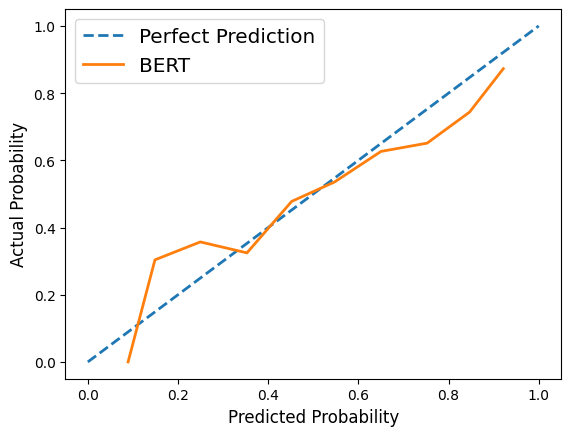

In [663]:
# plot base reliability diagram

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

reliability = calibration_curve(df_merged.label, df_merged.prob, n_bins=10, pos_label=1)

plt.xlabel('Predicted Probability', size=12)
plt.ylabel('Actual Probability', size=12)

line1, = plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
line2, = plt.plot(reliability[1], reliability[0], linewidth=2)
legend = plt.legend(handles = [line1, line2], labels = ['Perfect Prediction', 'BERT'],fontsize='x-large')

plt.savefig('bert-oob-platt.svg', bbox_inches="tight")

In [664]:
print('Expected Calibration Error (ECE)', np.mean(np.abs(reliability[0] - reliability[1])))

Expected Calibration Error (ECE) 0.06943635316127139


In [665]:
df_merged['label'].value_counts()

1    714
0    553
Name: label, dtype: int64

In [666]:
df_merged['label_binary'].value_counts()

1    814
0    453
Name: label_binary, dtype: int64

In [667]:
df_merged['match'] = df_merged['label'] == df_merged['label_binary']

In [668]:
df_merged['match'].value_counts()

True     825
False    442
Name: match, dtype: int64

In [669]:
# calibrate

from sklearn.calibration import CalibratedClassifierCV
import numpy as np

class dummy_classifier():
  def __init__(self):
    self.classes_ = [0,1]
  def predict_proba(self, X):
    print(np.vstack([X, 1 - X]).T.shape)
    return np.vstack([X, 1 - X]).T
  def fit(self, X_probs):
    return self

passthrough_classifier = dummy_classifier()

calibrated_clf = CalibratedClassifierCV(passthrough_classifier, method='sigmoid', cv='prefit')
calibrated_clf.fit(df_merged.prob, df_merged.label)

calibrated_preds = calibrated_clf.predict_proba(df_merged.prob)

(1267, 2)
(1267, 2)


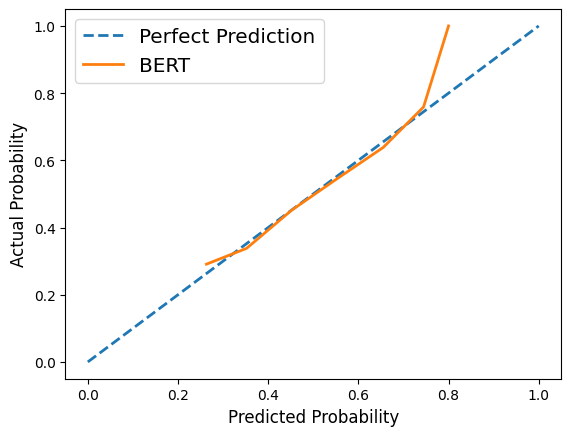

In [670]:
reliability = calibration_curve(df_merged.label, calibrated_preds[:,1], n_bins=10, pos_label=1)

plt.xlabel('Predicted Probability', size=12)
plt.ylabel('Actual Probability', size=12)

line1, = plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
line2, = plt.plot(reliability[1], reliability[0], linewidth=2)
legend = plt.legend(handles = [line1, line2], labels = ['Perfect Prediction', 'BERT'],fontsize='x-large')

plt.savefig('bert-calibration-platt.svg', bbox_inches="tight")

In [671]:
print('Expected Calibration Error (ECE)', np.mean(np.abs(reliability[0] - reliability[1])))

Expected Calibration Error (ECE) 0.0401166757167059


In [672]:
# calibrate another way

import torch
from torch import nn, optim
from torch.nn import functional as F


class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece


class dummy_classifier(nn.Module):
  def __init__(self):
    super(dummy_classifier, self).__init__()
    self.classes_ = [0,1]
  def forward(self, X):
    print(torch.stack([X, 1-X], dim=1).size())
    return torch.stack([X, 1-X], dim=1)

train_data = []
for i in range(len(df_merged.prob)):
   train_data.append([df_merged.prob[i], df_merged.label[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)

passthrough_classifier = dummy_classifier()

scaled_model = ModelWithTemperature(passthrough_classifier)
scaled_model.set_temperature(trainloader)

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([67, 2])
Before temperature - NLL: 0.808, ECE: 0.254
Optimal temperature: 1.856
After temperature - NLL: 0.748, ECE: 0.208


ModelWithTemperature(
  (model): dummy_classifier()
)

In [673]:
calibrated_preds = []
for batch in trainloader:
  data = batch[0].to('cuda:0')
  logits = scaled_model(data).detach().cpu()
  softmaxes = F.softmax(logits, dim=1)
  confidences, predictions = torch.max(softmaxes, 1)
  calibrated_preds += confidences.tolist()

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([67, 2])
